In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Using my GPU for faster execution 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Load and sort the training dataset by 'breath_id' and 'time_step'
df = pd.read_csv("data/train.csv")
df = df.sort_values(['breath_id', 'time_step'])

In [4]:
features = ['R', 'C', 'time_step', 'u_in', 'u_out']
# Group the data by breath_id to form sequences for LSTM input
grouped = df.groupby('breath_id')

In [5]:
###########################################
# Data Preparation: Grouping by Breath
###########################################

X_sequences = []
y_sequences = []
for breath_id, group in grouped:
    group = group.sort_values('time_step')
    X_sequences.append(group[features].values)
    y_sequences.append(group['pressure'].values)

# Convert lists to numpy arrays
X_sequences = np.array(X_sequences)  
y_sequences = np.array(y_sequences)
# Reshape targets to have an extra dimension for regression output
y_sequences = y_sequences.reshape(y_sequences.shape[0], y_sequences.shape[1], 1)

print("X_sequences shape:", X_sequences.shape)
print("y_sequences shape:", y_sequences.shape)

# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

X_sequences shape: (75450, 80, 5)
y_sequences shape: (75450, 80, 1)


In [6]:
###########################################
# Create a PyTorch Dataset and DataLoader
###########################################

class BreathDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = BreathDataset(X_train_tensor, y_train_tensor)
val_dataset = BreathDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [7]:
###########################################
# Define the LSTM Model using PyTorch
###########################################

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=1, dropout=0.2):
        super(BiLSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size1 * 2, hidden_size2, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size2 * 2, output_size)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = self.fc(out)
        return out

input_size = len(features)

In [8]:
###########################################
# Function to Train Model and Return Best Validation MSE
###########################################
def train_bilstm(hidden_size1, hidden_size2, num_epochs=100, patience=10):
    model = BiLSTMModel(input_size=input_size, hidden_size1=hidden_size1, hidden_size2=hidden_size2).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_losses.append(loss.item())
        avg_val_loss = np.mean(val_losses)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    return best_val_loss

In [9]:
###########################################
# Sensitivity Analysis: Number of Neurons in the First LSTM Layer
###########################################
# Let's try hidden_size1 values and set hidden_size2 as half of hidden_size1.
hidden_sizes = [50, 100, 150, 200, 250, 300]
results = []

for hs in hidden_sizes:
    hidden_size1 = hs
    hidden_size2 = hs // 2  # for example, half the number of neurons in the second layer
    best_val_mse = train_bilstm(hidden_size1, hidden_size2, num_epochs=100, patience=10)
    results.append((hidden_size1, best_val_mse))
    print(f"Hidden Size1: {hidden_size1}, Best Validation MSE: {best_val_mse:.4f}")


Hidden Size1: 50, Best Validation MSE: 0.5015
Hidden Size1: 100, Best Validation MSE: 0.3023
Hidden Size1: 150, Best Validation MSE: 0.2660
Hidden Size1: 200, Best Validation MSE: 0.2574
Hidden Size1: 250, Best Validation MSE: 0.2616
Hidden Size1: 300, Best Validation MSE: 0.2573


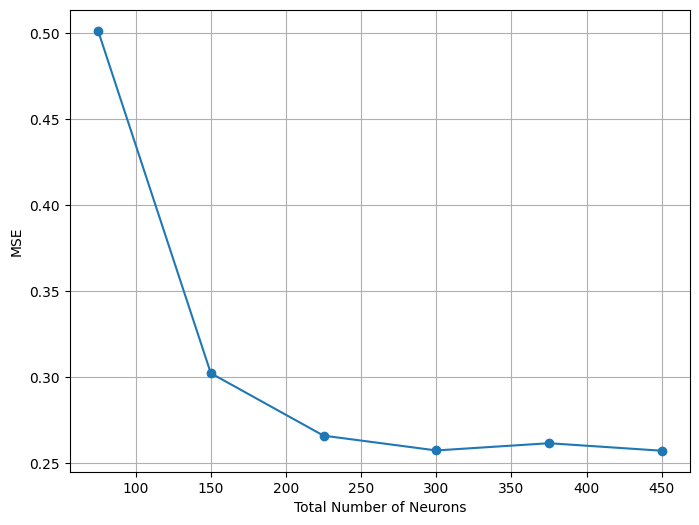

In [14]:
###########################################
# Plot Sensitivity Analysis: MSE vs Number of Neurons
###########################################
total_neurons = [int(hs + hs // 2) for hs, _ in results] # (because I forgot to append the total # of neuron above)
mse_values = [mse for _, mse in results]

plt.figure(figsize=(8, 6))
plt.plot(total_neurons, mse_values, marker='o', linestyle='-')
plt.xlabel('Total Number of Neurons')
plt.ylabel('MSE')
# plt.title('Sensitivity Analysis: MSE vs. Total Number of Neurons')
plt.grid(True)
plt.show()